# Continual learning of sequence patterns with online learning algorithms

In this notebook, we show how to perform the continual training of a RNN model on a sequence generation task.

Prerequisites: numpy, pytorch, matplotlib, tqdm, pickle, scikit-optimize

In [1]:
import numpy as np
import torch
import torch.nn
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import pickle as pk
import skopt
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
import numpy as np
from skopt.plots import plot_convergence

## Data set

We use a dataset of continuous trajectories in 2D. The models are trained to generate 20 trajectories from this dataset in an incremental fashion. We perform 300 iterations of supervised training on each trajectory. The models are evaluated according to their final prediction accuracy on the whole 20 trajectories.

In [2]:
trajs = pk.load(open('simple_trajectories_250.pk', 'rb'))
trajs = torch.Tensor(trajs[:, ::20]).transpose(0, 1)

## Models

We focus on RNN models where learning can be performed in a completely online fashion, meaning that any update rule based on past activations is prohibited (this includes BPTT). We consider several learning mechanisms that validate this criterion, that we separate according to the type of weight parameters they can be applied to:
- Output weights
    - Stochastic gradient descent (ESN)
    - Conceptor-aided gradient descent (Conceptors)
    - Random search (OutRS)
- Recurrent weights
    - Predictive Coding learning rule based on transposed feedback weights (PC-RNN-V)
    - Predictive Coding learning rule based on learned feedback weights, using the output weights learning rule for the feedback weights (PC-RNN-Hebb)
    - Predictive Coding learning rule based on learned feedback weights, using a custom learning rule for the feedback weights ([P-TNCN](https://arxiv.org/abs/1810.07411))
    - Random search (RecRS)
- Input weights
    - Predictive Coding learning rule with an additive influence of the input (PC-RNN-HC-A)
    - Predictive Coding learning rule with a multiplicative influence of the input (PC-RNN-HC-M)
    - Random search with an additive influence of the input (PC-RNN-HC-A-RS)
    - Random search with a multiplicative influence of the input (PC-RNN-HC-M-RS)
    
The source code for all models is provided in the file ```rnn_models.py```. 

In [3]:
from rnn_models import *

## Hyperparameter optimization

We test all models using the same hidden layer dimension of $300$. Other hyperparameters are found using an hyperparameter optimizer based on Gaussian processes. We optimize the different learning rates, as well as some other parameters like the aperture coefficient in Conceptors, and the standard deviation of the random search. When relevant, the RNN time constant is set to $50$, and the update rate in PC-based model is set to $10^{-5}$.

Since the OutRS and RecRS models performed extremely poorly, we only performed hyperparameter search on the remaining models. Here are the found hyperparemeters:

- Output weights
    - ESN
        - learning rate $\lambda=3,3.10^{-6}$
    - Conceptors
        - learning rate $\lambda=8,9.10^{-5}$
        - aperture $\alpha=1,2$
- Recurrent weights
    - PC-RNN-V
        - output learning rate $\lambda=1,9.10^{-6}$
        - reccurent learning rate $\lambda_r=53,4$
    - PC-RNN-Hebb
        - output learning rate $\lambda=3,4.10^{-6}$
        - feedback learing rate $\lambda_f=3,4.10^{-6}$ (actually no impact because the recurrent learning rate is too low)
        - reccurent learning rate $\lambda_r=0,04$
    - P-TNCN
        - output learning rate $\lambda=3,7.10^{-6}$
        - feedback learing rate $\lambda_f=3,7.10^{-6}$ (actually no impact because the recurrent learning rate is too low)
        - reccurent learning rate $\lambda_r=0,01$
- Input weights
    - PC-RNN-HC-A
        - output learning rate $\lambda=8,3.10^{-6}$
        - reccurent learning rate $\lambda_r=0,1$
        - input learning rate $\lambda_c=2.10^5$
    - PC-RNN-HC-M
        - output learning rate $\lambda=6,3.10^{-5}$
        - reccurent learning rate $\lambda_r=3,1$
        - input learning rate $\lambda_c=1,1.10^5$
    - PC-RNN-HC-A-RS
        - output learning rate $\lambda=6,8.10^{-6}$
        - reccurent learning rate $\lambda_r=4,4$
        - input learning rate $\lambda_c=6.10^5$
    - PC-RNN-HC-M-RS
        - output learning rate $\lambda=6.10^{-6}$
        - reccurent learning rate $\lambda_r=1,1$
        - input learning rate $\lambda_c=1.10^5$

## Example training with optimal hyperparameters

As an example, we train here the PC-RNN-HC-A model with the found optimal hyperparameters

In [5]:
p = 20
iterations = 300

n=300
alpha=1e-5
tau = 50

seeds = 5

# Errors
errors = np.zeros((seeds, p, iterations, p))

for s in range(seeds):
    
    ######################################################
    # Training of the model
    
    # Initialize ESN
    rnn = PC_RNN_HC_A(p, n, 2, tau_h=50, alpha_x=alpha, alpha_h=0)
    
    # Shuffle dataset
    l = np.arange(250)
    np.random.shuffle(l)
    l = l[:p]

    # Initial states
    h_init = torch.randn(p, rnn.states_dim)
    c_init = torch.eye(p)
    
    for j in tqdm(range(p)):

        for i in range(iterations):
            
            # What would be the current error on the complete dataset
            error = rnn.forward(trajs[:, l], c_init, h_init)
            errors[s, j, i] = np.mean(np.sqrt(np.sum(error.detach().numpy()**2, axis=2)), axis=0)

            # Forward pass only on the current task for learning
            error = rnn.forward(trajs[:, l[j:j+1]], c_init[j:j+1], h_init[j:j+1])

            # Learning
            rnn.learn(lr=8.3e-6, lr_r=0.1, lr_c=2e5)
            
    ########################################################


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

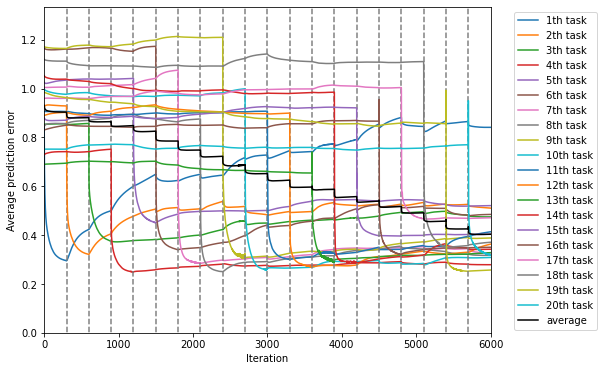

In [12]:
mean_errors = np.mean(np.mean(errors, axis=0), axis=-1).reshape(p*iterations)

plt.figure(figsize=(8, 6))

for k in range(p):
    if k>0:
        plt.plot([k*iterations, k*iterations], [-1, 10], '--', c='grey')
    plt.plot(np.mean(errors, axis=0).reshape(p*iterations, p)[:, k], label=str(k+1)+'th task')

plt.plot(mean_errors, c='black', label='average')

plt.xlim(0, p*iterations)
plt.xlabel("Iteration")

plt.ylim(0, 1.1*np.max(np.mean(errors, axis=0)))
# plt.ylim(0, 1.4)
plt.ylabel("Average prediction error")

plt.legend(bbox_to_anchor=(0.0, 0.0, 1.25, 1.0))

plt.show()